In [1]:
import dill
import numpy as np
import agent
import environment
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import pandas as pd

In [2]:
def train_agent(learner, env, alpha, epsilon, episodes, episode_lenght, initial="random", verbose=False):
# perform the training
    rewards_log = []
    for index in range(0, episodes):
        
        
        # start from a random state
        if initial == "random":
            initial = [np.random.randint(0, x), np.random.randint(0, y)]
        # initialize environment
        ##checking if initial and goal state are the same
        bool_init = (initial == env.goal or initial in env.walls)
        while (bool_init):
            if initial == "random":
                initial = [np.random.randint(0, x), np.random.randint(0, y)]
            else: 
                print("Initial state cannot correspond to either goal or walls")
                break
        if bool_init:
            break
        state = initial
        
        #initializes starting point keeping boundaries and goal fixed
        env.initialize_start(initial)
        reward = 0
        # run episode
        for step in range(0, episode_length):
            # find state index
            state_index = state[0] * y + state[1]
            # choose an action
            action = learner.select_action(state_index, epsilon[index]) #epsilon decade tra gli episodi
            # the agent moves in the environment
            result = env.move(action)
            # Q-learning update
            next_index = result[0][0] * y + result[0][1]
            learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
            # update state and reward
            reward += result[1]
            state = result[0]
        reward = reward / episode_length
        rewards_log.append(reward)
        if verbose:
            print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    if verbose:
        fig, ax = plt.subplots(1,1, figsize=(8,7))
        ax.scatter(episodes, rewards_log)
        ax.set_xlabel("Episode", fontsize=15)
        ax.set_ylabel("Reward per step", fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=10)
        fig.tight_layout()
        plt.show()
    return rewards_log, learner

def test_agent(learner, env, episode_lenght, initial, plot=True):
    if initial == "random":
        initial = [np.random.randint(0, x), np.random.randint(0, y)]
    # initialize environment
    state = initial
    #initializes starting point keeping boundaries and goal fixed
    env.initialize_start(initial)
    reward = 0
    states_log = [state]
    
    for step in range(0, episode_length):
        # find state index
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon="greedy") #epsilon è più greedy possibile
        # the agent moves in the environment
        result = env.move(action)
        state = result[0]
        states_log.append(state)
             
    return states_log

def plot_moves(learner, env, states_log, title, moves=True, color_map=True):

    dim = learner.qtable.shape[0]
    
    plt.figure(figsize=(6,6))
    #plot maze
    plt.imshow(env.maze.transpose(), cmap="Greys", origin="lower")
    #plot heatmap of expected reward
    if color_map:
        exp_reward = np.amax(learner.qtable, axis=1)
        plt.imshow(exp_reward.reshape(10,-1).transpose(), origin='lower')
    #plot goal and start
    plt.scatter(env.goal[0], env.goal[1], s=200, c='magenta', marker='o', alpha=0.5) #goal
    plt.scatter(env.start[0], env.start[1], s=200, c='magenta', marker="*", alpha=0.5) #start
    #plot path
    for step in states_log:
        plt.scatter(step[0], step[1], s=100, c= 'magenta', marker=".")

    #plotting the best move for each position
    if moves: 
        exp_reward = np.amax(learner.qtable, axis=1)
        exp_move = np.argwhere(np.vstack((exp_reward,exp_reward,exp_reward,exp_reward,exp_reward)).transpose() == learner.qtable)
        exp_move = np.split(exp_move[:,1], np.unique(exp_move[:, 0], return_index=True)[1][1:])
        for i in range(10):
            for j in range(10):
                if [i,j] in env.walls:
                    pass
                else:
                    plt.text(i, j, exp_move[i*10 + j], ha="left", va="top", color="red")
                
    # Major ticks
    plt.xticks(np.arange(0, 10, 1))
    plt.yticks(np.arange(0, 10, 1))

    # Labels for major ticks
    ax = plt.gca()
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

    # Gridlines based on minor ticks
    plt.grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
    
def epsilon(choice, episodes):
    ei = 0.8
    ef = 0.001
    l = 3
    if choice == "lin":
        return np.linspace(ei, ef, episodes)
    elif "exp":
        return ef + (ei-ef)*np.exp(-l*np.arange(episodes)/episodes)
    

In [3]:
#%% Setting parametrs and initializing agent and env
episodes = 2000       # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
state = [7,8]           # starting point
goal = [0,3]           # objective point
discount = 0.9         # exponential discount factor
softmax = False      # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm

# Initial analysis

In [ ]:
# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001, episodes)

# initialize the agent
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=softmax, sarsa=sarsa)
env = environment.Environment(x, y, state, goal)

In [ ]:
#%% Training
training=False
if training:
    rewards_log, learner = train_agent(learner, env, alpha, epsilon, episodes, episode_length, initial=state)

In [ ]:
test=False
if test:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, title="initial.png")

# Performances of combinations

In [ ]:
# FIXED PARAMETERS
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
state = [7,8]           # starting point
goal = [0,3]            # objective point
discount = 0.9          # exponential discount factor
alpha = np.ones(episodes) * 0.25

In [ ]:
#SEARCHED 
softmax_choice = [True, False] 
sarsa_choice = [True, False]         
epsilon_choice = ["lin", "exp"]
combinations = list(product(*[softmax_choice,sarsa_choice,epsilon_choice]))
filename = "combinations.csv"
names=["softmax","sarsa","epsilon"]
list_of_models = pd.DataFrame(combinations, columns=names)
list_of_models.to_csv(filename,index=False)

In [ ]:
search = False
if search :
    repetitions=20

    mrps = []
    i=0
    for choices in combinations:
        print("Training combination %d of %d" %(i, len(combinations)))
        softmax = choices[0]
        sarsa = choices[1]
        eps = epsilon(choices[2], episodes)

        log = []

        for rep in tqdm(range(repetitions), leave=True):
            learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=softmax, sarsa=sarsa)
            env = environment.Environment(x, y, state, goal)
            rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
            log.append(rewards_log)

        #compute mean reward per step (mrps) for each episode averaged over repetitions for given set of parameters
        mrps.append(np.array(log).mean(axis=0))
        i+=1

    np.savetxt("mrps.txt", np.array(mrps))
else:
    print("Flag is set to False so nothing happened")

# Analysis

In [ ]:
# FIXED PARAMETERS
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
state = [7,8]           # starting point
goal = [0,3]            # objective point
discount = 0.9          # exponential discount factor
alpha = np.ones(episodes) * 0.25

#SEARCHED
def epsilon(choice, episodes):
    ei = 0.8
    ef = 0.001
    l = 3
    if choice == "lin":
        return np.linspace(ei, ef, episodes)
    elif "exp":
        return ef + (ei-ef)*np.exp(-l*np.arange(episodes)/episodes)

In [ ]:
pars_choice = pd.read_csv("combinations.csv")
sarsas = pars_choice[pars_choice['sarsa']==True].index.tolist() 
qlearnings = pars_choice[pars_choice['sarsa']==False].index.tolist() 

data = np.loadtxt("mrps.txt")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

for i in qlearnings:
    label = "Softmax: "+str(pars_choice.iloc[i]["softmax"])+", Epsilon decay: "+str(pars_choice.iloc[i]["epsilon"])
    ax[0].scatter(np.arange(episodes), data[i], label=label, s=2)
    ax[0].set_xlabel("Episode", fontsize=15)
    ax[0].set_ylabel("MRPS", fontsize=15)
    ax[0].set_title("Q-Learning", fontsize=18)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].tick_params(axis='both', which='minor', labelsize=10)
    ax[0].legend(fontsize=13, markerscale=5, loc=4)
    
for i in sarsas:
    label = "Softmax: "+str(pars_choice.iloc[i]["softmax"])+", Epsilon decay: "+str(pars_choice.iloc[i]["epsilon"])
    ax[1].scatter(np.arange(episodes), data[i], label=label, s=2)
    ax[1].set_xlabel("Episode", fontsize=15)
    ax[1].set_ylabel("MRPS", fontsize=15)
    ax[1].set_title("Sarsa", fontsize=18)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].tick_params(axis='both', which='minor', labelsize=10)
    ax[1].legend(fontsize=13, markerscale=5, loc=4)

fig.tight_layout()
fig.savefig("combiantions.png")
plt.show()

# The maze

## Softmax

In [4]:
# FIXED PARAMETERS
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
state = [9,1]           # starting point
goal = [0,5]            # objective point
discount = 0.9         # exponential discount factor
alpha = np.ones(episodes) * 0.25
eps = epsilon("exp", episodes)

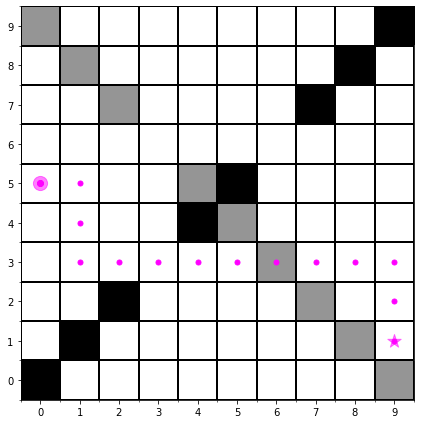

In [5]:
#QLEARNING
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=False)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "qlearning_softmax_"+str(discount)+".png", False, False)     

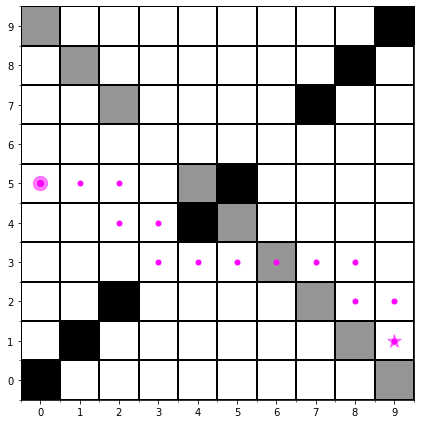

In [6]:
#SARSA
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=True)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "sarsa_softmax_"+str(discount)+".png",False, False)

In [7]:
discount=0.8

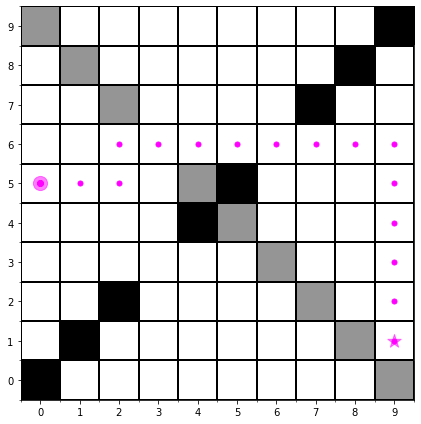

In [8]:
#QLEARNING
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=False)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "qlearning_softmax_"+str(discount)+".png", False, False)      

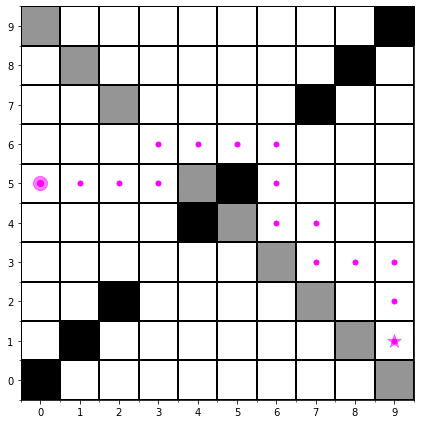

In [9]:
#SARSA
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=True)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "sarsa_softmax_"+str(discount)+".png",False, False)

### Linear

In [ ]:
#QLEARNING + lin
eps = epsilon("lin", episodes)
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=False)
training=False
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "qlearning_softmax_lin.png", True, False)    

In [ ]:
#SARSA + lin
eps = epsilon("lin", episodes)
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=True)
training=False
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "sarsa_softmax_lin.png", True, False)    

## $\epsilon$ greedy

In [10]:
# FIXED PARAMETERS
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
state = [9,1]           # starting point
goal = [0,5]            # objective point
alpha = np.ones(episodes) * 0.25
eps = epsilon("exp", episodes)

In [11]:
discount = 0.9    # exponential discount factor

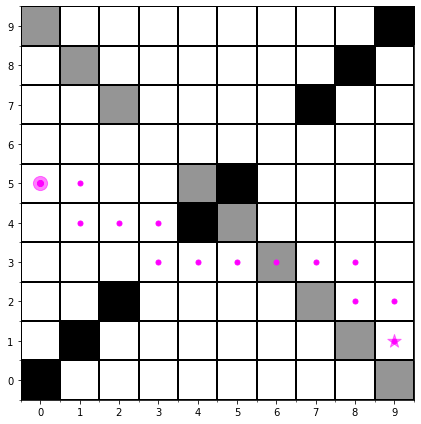

In [12]:
#QLEARNING
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=False, sarsa=False)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "qlearning_epsgreedy_"+str(discount)+".png", False, False)    

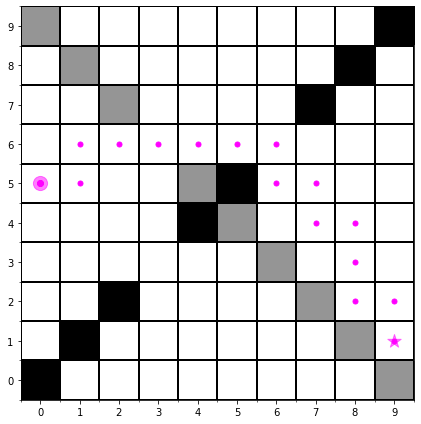

In [13]:
#SARSA
discount=0.9

walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=False, sarsa=True)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "sarsa_epsgreedy_"+str(discount)+".png", False, False)

In [14]:
discount = 0.8    # exponential discount factor

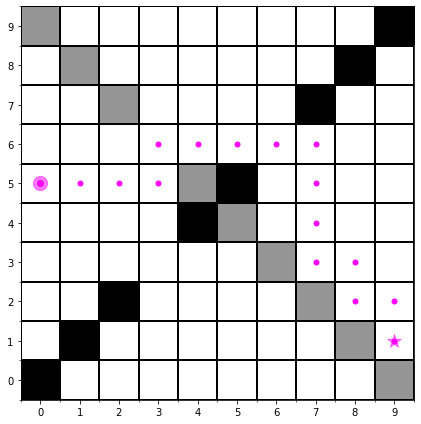

In [15]:
#QLEARNING
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=False, sarsa=False)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "qlearning_epsgreedy_"+str(discount)+".png", False, False)    

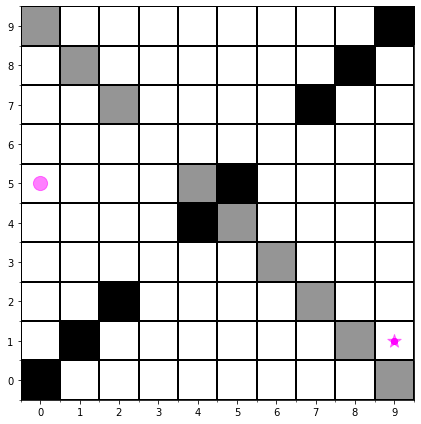

In [16]:
#SARSA
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=False, sarsa=True)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "sarsa_epsgreedy_"+str(discount)+".png", False, False)

## Changing swamp reward

In [17]:
swamp_reward=-0.60

### Softmax

In [18]:
# FIXED PARAMETERS
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
state = [9,1]           # starting point
goal = [0,5]            # objective point
discount = 0.9         # exponential discount factor
alpha = np.ones(episodes) * 0.25
eps = epsilon("exp", episodes)

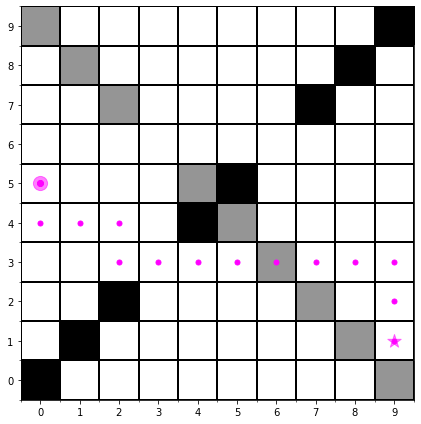

In [19]:
#QLEARNING
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps, swamp_reward=swamp_reward)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=False)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "qlearning_softmax_"+str(discount)+"_"+str(swamp_reward)+".png", False, False)     

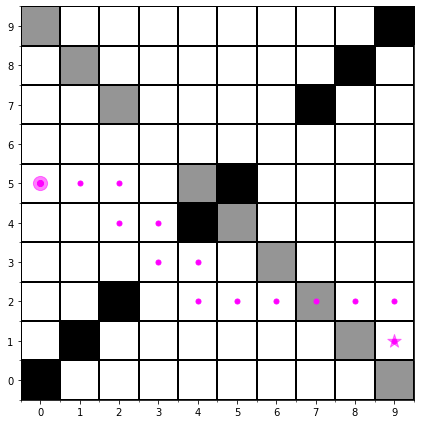

In [20]:
#SARSA
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps, swamp_reward=swamp_reward)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=True, sarsa=True)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "sarsa_softmax_"+str(discount)+"_"+str(swamp_reward)+".png",False, False)

### $\epsilon$ greedy

In [21]:
# FIXED PARAMETERS
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
state = [9,1]           # starting point
goal = [0,5]            # objective point
alpha = np.ones(episodes) * 0.25
eps = epsilon("exp", episodes)

In [22]:
discount = 0.9    # exponential discount factor

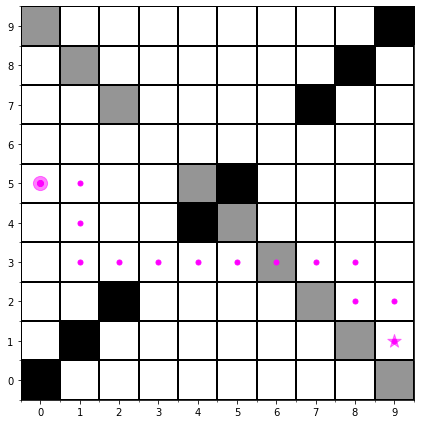

In [23]:
#QLEARNING
walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps, swamp_reward=swamp_reward)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=False, sarsa=False)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "qlearning_epsgreedy_"+str(discount)+"_"+str(swamp_reward)+".png", False, False)    

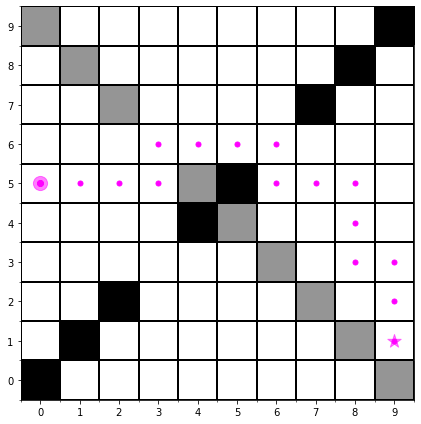

In [24]:
#SARSA
discount=0.9

walls=[[0,0],[1,1],[2,2,],[4,4],[5,5],[7,7],[8,8],[9,9]]
swamps = [[9,0],[8,1],[7,2],[5,4],[4,5],[6,3],[2,7],[1,8],[0,9]]
env = environment.Environment(x, y, state, goal, walls=walls, swamps=swamps, swamp_reward=swamp_reward)
learner = agent.Agent(states=(x * y), actions=5, discount=discount, max_reward=1, softmax=False, sarsa=True)
training=True
if training:
    rewards_log, learner = train_agent(learner, env, alpha, eps, episodes, episode_length, initial=state)
if training:
    path = test_agent(learner, env, episode_length, initial=state)
    plot_moves(learner, env, path, "sarsa_epsgreedy_"+str(discount)+"_"+str(swamp_reward)+".png", False, False)